In [11]:
# Importing necessary libraries
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

plt.style.use('dark_background')

In [12]:
# Constants for the input image size, batch size, and number of timesteps
IMG_SIZE = 32     # CIFAR-10 images are 32x32 pixels
BATCH_SIZE = 128  # Batch size for training
timesteps = 16    # Number of steps to transition from a noisy image to a clear one

# Creating a linear space for the noise and clarity levels over the timesteps
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1)

# Setting the device to GPU if available, otherwise CPU
use_cuda = torch.cuda.is_available()
use_mps  = torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using", device)

Using mps


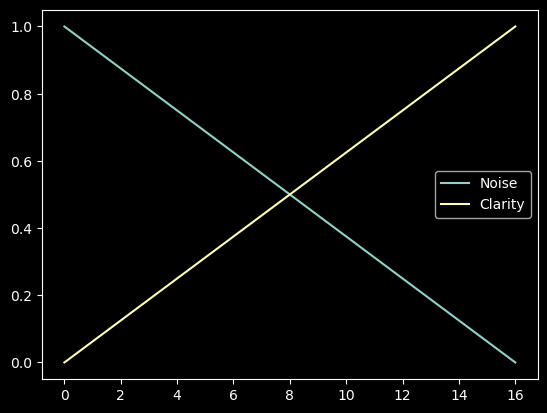

In [13]:
# Plotting the noise and clarity levels over the timesteps
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend()

In [14]:
# Preparing the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filtering training images to include only those with label 1
idx = [i for i, (img, label) in enumerate(all_trainset) if label == 1]
sub_trainset = torch.utils.data.Subset(all_trainset, idx)

# Creating a DataLoader to handle batching and shuffling of data
trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


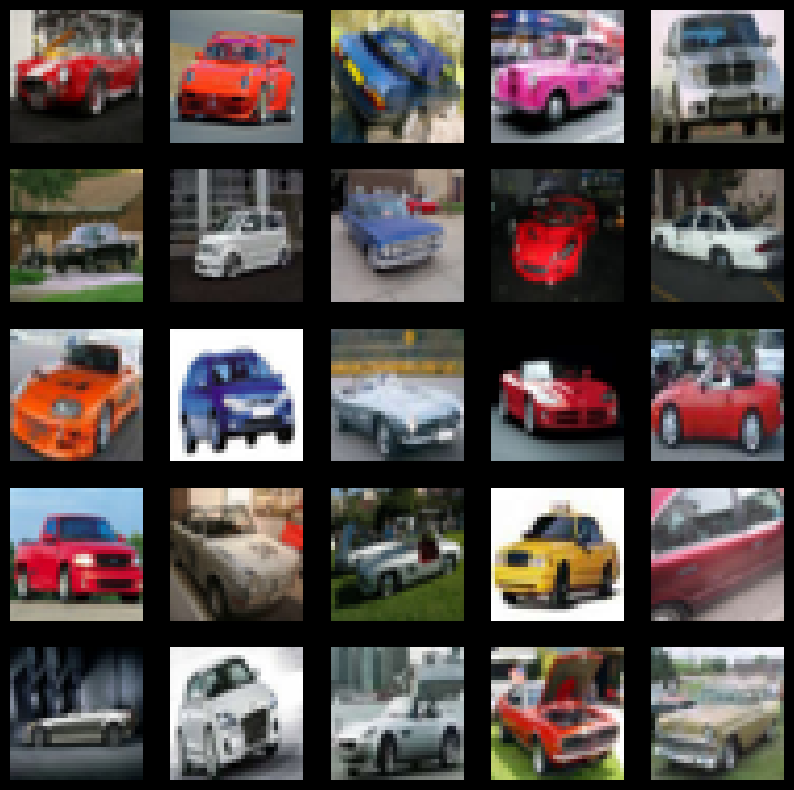

In [15]:
# Function to convert images to a format suitable for displaying with matplotlib
def cvtImg(img):
    img = img.permute([0, 2, 3, 1])  # Changing from (batch, channels, height, width) to (batch, height, width, channels)
    img = img - img.min()  # Normalizing to range [0, 1]
    img = img / img.max()
    return img.numpy().astype(np.float32)

# Function to display a batch of images
def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(imgs[i])
        plt.axis('off')

# Displaying examples from the dataset
x, _ = next(iter(trainloader))
show_examples(x)

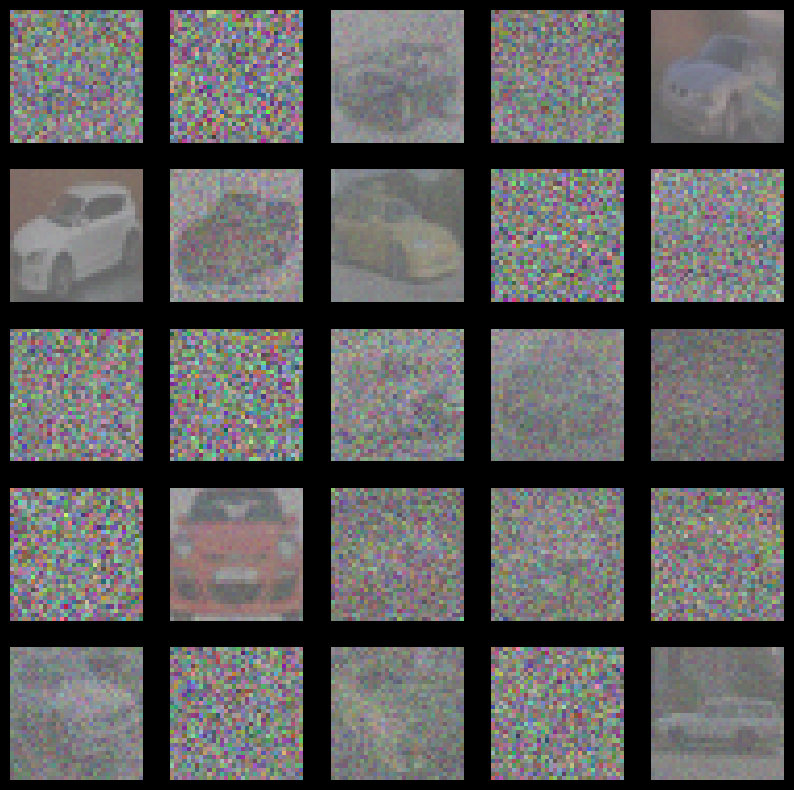

In [16]:
# Function to add noise to images based on the timestep
def forward_noise(x, t):
    a = time_bar[t]      # Noise level for the current timestep
    b = time_bar[t + 1]  # Noise level for the next timestep
    
    noise = np.random.normal(size=x.shape)  # Generating a noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a  # Adding noise to the image for the current timestep
    img_b = x * (1 - b) + noise * b  # Adding noise to the image for the next timestep
    return img_a, img_b

# Function to generate random timesteps for a batch of images
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# Displaying noisy images based on random timesteps
t = generate_ts(25)
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)

In [7]:
# Defining a block for the diffusion model

class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()
        
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # Time embedding layer: transforms a single time value into a 192-dimensional vector
        # followed by Layer Normalization and ReLU activation.
        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )
        
        # Defining the down-sampling blocks with different sizes
        self.down_x32 = Block(in_channels=3, size=32)  # Initial block for 32x32 input images
        self.down_x16 = Block(size=16)  # Block for 16x16 feature maps
        self.down_x8 = Block(size=8)    # Block for 8x8 feature maps
        self.down_x4 = Block(size=4)    # Block for 4x4 feature maps
        
        # Multilayer Perceptron: Processes flattened feature maps and time embeddings
        # First layer transforms input to 128-dimensional space
        # Second layer transforms it to the size required for feature map concatenation (32x4x4)
        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),
            
            nn.Linear(128, 32 * 4 * 4),  # Shape for concatenation with feature maps / make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )
        
        # Defining the up-sampling blocks with different input sizes and output sizes
        self.up_x4  = Block(in_channels=32 + 128, size=4)  # Block for up-sampling to 4x4 feature maps
        self.up_x8  = Block(in_channels=256, size=8)        # Block for up-sampling to 8x8 feature maps
        self.up_x16 = Block(in_channels=256, size=16)      # Block for up-sampling to 16x16 feature maps
        self.up_x32 = Block(in_channels=256, size=32)      # Block for up-sampling to 32x32 feature maps
        
        # Output layer: a 1x1 convolution to transform feature maps back to 3-channel image
        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
        
        # Optimizer: Adam optimizer with a learning rate of 0.0008
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)
    
    def forward(self, x, x_ts):
        # Embedding the timestep
        x_ts = self.l_ts(x_ts)
        
        # Down-sampling (left) part of the U-Net architecture
        blocks = [self.down_x32, self.down_x16, self.down_x8, self.down_x4]
        x_left_layers = []  # to store feature maps at different resolutions
        for i, block in enumerate(blocks):
            x = block(x, x_ts)  # passing through the block
            x_left_layers.append(x)  # storing the feature map
            if i < len(blocks) - 1:  # if not the last block, apply max pooling
                x = F.max_pool2d(x, 2)
                
        # Multilayer Perceptron: processing the feature maps
        x = x.view(-1, 128 * 4 * 4)  # flattening
        x = torch.cat([x, x_ts], dim=1)  # concatenating time embedding
        x = self.mlp(x)  # passing through the MLP
        x = x.view(-1, 32, 4, 4)  # reshaping to feature maps
        
        # Up-sampling (right) part of the U-Net architecture
        blocks = [self.up_x4, self.up_x8, self.up_x16, self.up_x32]
        for i, block in enumerate(blocks):
            x_left = x_left_layers[len(blocks) - i - 1]  # retrieving corresponding feature map from the down-sampling part
            x = torch.cat([x, x_left], dim=1)  # concatenating feature maps
            x = block(x, x_ts)  # passing through the block
            if i < len(blocks) - 1:  # if not the last block, apply bilinear up-sampling
                x = F.interpolate(x, scale_factor=2, mode='bilinear')
                
        # Output layer: transforming feature maps back to 3-channel image
        x = self.cnn_output(x)
        return x

# Creating the model and moving it to the device (CPU or GPU)
model = Model().to(device)


100%|██████████| 16/16 [00:00<00:00, 65.75it/s]


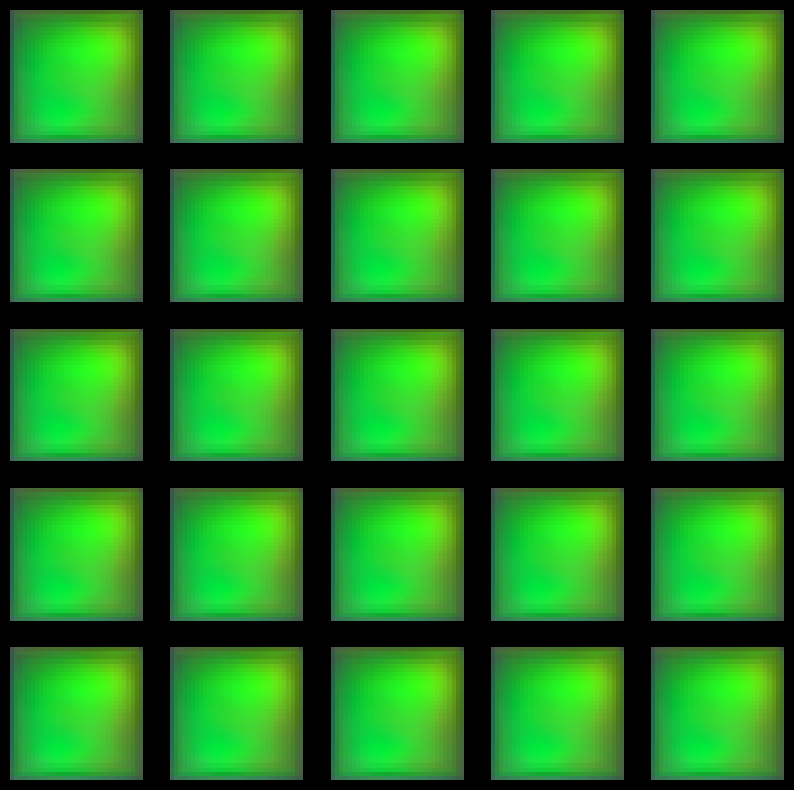

In [17]:
# Define a function for prediction
def predict(x_idx=None):
    # Generate a random tensor of size [32, 3, IMG_SIZE, IMG_SIZE]
    # representing a batch of 32 images with 3 channels and spatial dimensions IMG_SIZE x IMG_SIZE.
    # The tensor is moved to the specified device (e.g., GPU or CPU).
    x = torch.randn(32, 3, IMG_SIZE, IMG_SIZE).to(device)
    
    # Disable gradient computation, as we are in inference mode and do not need to backpropagate errors.
    with torch.no_grad():
        # Iterate through the timesteps.
        for i in trange(timesteps):
            t = i  # Set the current timestep.
            # Make a prediction using the model, passing in the current image tensor and the current timestep.
            # torch.full creates a tensor of size [32, 1] filled with the current timestep value, t.
            # The tensor is moved to the specified device.
            x = model(x, torch.full([32, 1], t, dtype=torch.float, device=device))
    
    # Move the predicted images back to CPU memory and visualize them using the show_examples function.
    show_examples(x.cpu())

# Call the prediction function.
predict()

100%|██████████| 16/16 [00:02<00:00,  6.67it/s]


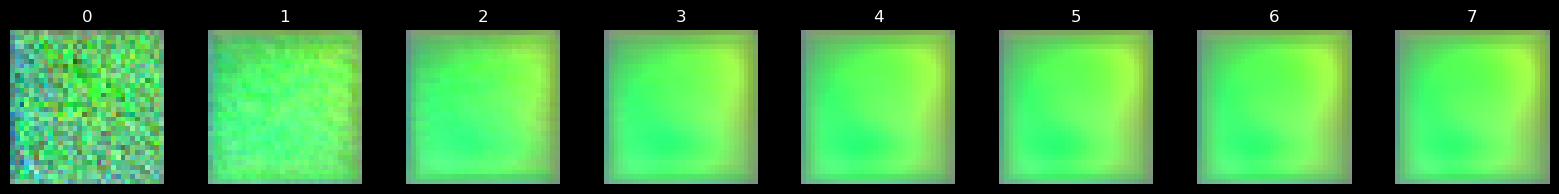

In [18]:
# Define a function to perform a prediction step-by-step and visualize intermediate results.
def predict_step():
    # Initialize a list to store intermediate results.
    xs = []
    
    # Generate a random tensor of shape [8, 3, IMG_SIZE, IMG_SIZE] to represent a batch of 8 images
    # with 3 channels (RGB) and spatial dimensions IMG_SIZE x IMG_SIZE. 
    # The tensor is created directly on the specified device (GPU or CPU).
    x = torch.randn(size=(8, 3, IMG_SIZE, IMG_SIZE), device=device)
    
    # Disable gradient computation since we are in inference mode.
    with torch.no_grad():
        # Iterate through the timesteps.
        for i in trange(timesteps):
            t = i  # Set the current timestep.
            
            # Update the image tensor by passing it through the model along with the current timestep.
            # torch.full creates a tensor of size [8, 1] filled with the value of t, placed on the same device as x.
            x = model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            
            # Every second timestep (0, 2, 4, ...), store the first image of the batch in the results list.
            # The image tensor is moved to CPU memory before appending.
            if i % 2 == 0:
                xs.append(x[0].cpu())
    
    # Stack the list of result tensors into a single tensor along a new dimension (axis 0).
    xs = torch.stack(xs, dim=0)
    
    # Clip the values of the result tensor to be within the range [-1, 1].
    xs = torch.clip(xs, -1, 1)
    
    # Convert the tensor to a format suitable for visualization.
    # The cvtImg function is assumed to perform this conversion and normalization.
    xs = cvtImg(xs)

    # Create a new matplotlib figure with specified size.
    plt.figure(figsize=(20, 2))
    
    # Visualize each image in the result tensor.
    for i in range(len(xs)):
        # Create a subplot for the current image.
        plt.subplot(1, len(xs), i+1)
        
        # Display the image.
        plt.imshow(xs[i])
        
        # Set the title of the subplot to the current timestep.
        plt.title(f'{i}')
        
        # Turn off the axis labels and ticks.
        plt.axis('off')

# Call the prediction step function to execute the code.
predict_step()


In [19]:
# Define a function to perform one training step for the model.
def train_one(x_img):
    # Generate a sequence of time steps based on the batch size of the input images.
    # The 'generate_ts' function is assumed to return a NumPy array of time steps.
    x_ts = generate_ts(len(x_img))

    # Apply noise to the input images at two different time steps, resulting in x_a and x_b.
    # The 'forward_noise' function is assumed to return two NumPy arrays.
    x_a, x_b = forward_noise(x_img, x_ts)

    # Convert the time steps, x_a, and x_b to PyTorch tensors and place them on the specified device.
    # The tensors are also converted to float32 and reshaped as needed.
    x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
    x_a = x_a.float().to(device)
    x_b = x_b.float().to(device)

    # Pass the noisy input (x_a) and time steps (x_ts) through the model to get the prediction (y_p).
    y_p = model(x_a, x_ts)

    # Calculate the Mean Absolute Error (MAE) loss between the prediction and the target (x_b).
    loss = torch.mean(torch.abs(y_p - x_b))

    # Reset the gradients of all the parameters in the model.
    model.opt.zero_grad()

    # Backpropagate the loss to compute gradients.
    loss.backward()

    # Update the parameters of the model based on the computed gradients.
    model.opt.step()

    # Return the loss value as a Python float.
    return loss.item()


In [20]:
# Define a function to perform the training of the model.
# R specifies the number of epochs, or complete passes through the entire training dataset.
def train(R=50):
    # Create a progress bar for the number of epochs using trange (from tqdm library), which adds a visual indicator.
    bar = trange(R)

    # Calculate the total number of batches in the training dataset.
    total = len(trainloader)

    # Loop through each epoch.
    for i in bar:
        # Loop through each batch of data in the training dataset.
        # 'trainloader' is assumed to be a DataLoader object that yields batches of image data and corresponding labels.
        for j, (x_img, _) in enumerate(trainloader):
            # Call the 'train_one' function to perform a training step on the current batch of image data.
            # The function returns the training loss for the current batch.
            loss = train_one(x_img)

            # Calculate the progress through the current epoch as a percentage.
            pg = (j / total) * 100

            # Every 5 batches, update the description of the progress bar to show the current loss and progress percentage.
            if j % 5 == 0:
                bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')


In [ ]:
# Perform 10 training sessions.
for _ in range(10):
    # Call the 'train' function to train the model. It's assumed that this function is defined elsewhere in the code.
    train()
    
    # After each training session, reduce the learning rate for the next training session.
    # 'model.opt' is assumed to be an optimizer object associated with the model, which holds the learning rate parameter.
    for pg in model.opt.param_groups:
        # Reduce the learning rate to 90% of its current value.
        # Ensure that it does not go below a threshold of 0.000001 to prevent it from becoming too small.
        pg['lr'] = max(0.000001, pg['lr'] * 0.9)

    # After each training session, display the results using the 'predict' and 'predict_step' functions.
    # These functions are assumed to generate and display images based on the current state of the model.
    predict()        # Call 'predict' to display one set of results.
    predict_step()   # Call 'predict_step' to display another set of results.

    # Show the plots that were generated by the 'predict' and 'predict_step' functions.
    plt.show()

In [ ]:
predict()
predict_step()